# Twin Rotor MIMO system
https://www.hindawi.com/journals/ddns/2016/2952738/

![image](trms.png)


In [195]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from scipy.signal import place_poles

In [19]:
trms_params = {
    'I1': 6.8e-2,
    'I2': 2e-2,
    'a1': 0.0135,
    'b1': 0.0924,
    'a2': 0.2,
    'b2': 0.09,
    'Mg': 0.32,
    'B1_psi': 6e-3,
    'B2_psi': 1e-3,
    'B1_phi': 0.1,
    'B2_phi': 0.01,
    'K_gy': 0.05,
    'k1': 1.1,
    'k2': 0.8,
    'T11': 1.1,
    'T10': 1,
    'T21': 1,
    'T20': 1,
    'Tp': 2,
    'T0': 3.5,
    'kc': -0.2,
    'u_upper': 2.5,
    'u_lower': -2.5
}

Вектор состояния:
$x^T = [\psi \quad \dot{\psi} \quad \varphi \quad \dot{\varphi} \quad \tau_1 \quad \tau_2 \quad M_R]$ 

$\dot{\psi}=\frac{1}{I_1}\left(M_1-M_{FG}-M_{B\psi}-M_G\right)$

$M_1=a_1\tau_1^2 + b_1\tau_1$

$M_{FG}=M_g \sin \psi$

$M_{B\psi}=B_{1\psi}\dot{\psi} + B_{2\psi}sign \dot{\psi}$

$M_G=k_{gy}M_1 \dot{\varphi} \cos \psi $

$\dot{\psi}=\frac{1}{I_2}\left(M_2-M_{FG}-M_{B\varphi}-M_R\right)$

$M_2 = a_2\tau_2^2 + b_2\tau_2$

$M_{B\varphi}=B_{1\varphi}\dot{\varphi} + B_{2\varphi} sign \dot{\varphi}$

$\dot{\tau}_1=\frac{1}{T_{11}}\left(-T_{10}\tau_{1} + k_1u_1 \right)$

$\dot{\tau}_2=\frac{1}{T_{21}}\left(-T_{20}\tau_{2} + k_2u_2 \right)$

# 1. Проверка модели

In [333]:
startTime=0
endTime=30
timeSteps=10000
simulationTime=np.linspace(startTime,endTime,timeSteps)

In [334]:
def plant_diff_eq2(t, x, trms_params, t_list, u_list):
    u1_list = u_list[0, :]
    u2_list = u_list[1, :]
    u1 = np.interp(t, t_list, u1_list)
    u2 = np.interp(t,t_list, u2_list)    
    if u1 > trms_params['u_upper']: u1 = trms_params['u_upper']
    elif u1 < trms_params['u_lower']: u1 = trms_params['u_lower']
    if u2 > trms_params['u_upper']: u2 = trms_params['u_upper']
    elif u2 < trms_params['u_lower']: u2 = trms_params['u_lower']    
    
    psi, dpsi, phi, dphi, tau1, tau2, M_R = x 
    
    dtau1_dt = (-trms_params['T10']*tau1 + trms_params['k1']*u1) / trms_params['T11']      
    dtau2_dt = (-trms_params['T20']*tau2 + trms_params['k2']*u2) / trms_params['T21']        
    
    M1 = trms_params['a1'] * tau1**2 +trms_params['b1'] * tau1
    M_FG = trms_params['Mg']*np.sin(psi)
    M_Bpsi = trms_params['B1_psi'] * dpsi + np.tanh(dpsi)    #+trms_params['B2_psi']*np.sign(dpsi)
    M_G = trms_params['K_gy'] * M1 * dphi * np.cos(psi)
    ddpsi_dt = (M1-M_FG-M_Bpsi-M_G)/trms_params['I1']       
       
    M2 = trms_params['a2'] * tau2**2 +trms_params['b2'] * tau2
    M_Bphi = trms_params['B1_phi'] * dphi + np.tanh(dphi) #+ trms_params['B2_phi'] * np.sign(dphi)
    ddphi_dt = (M2 - M_Bphi - M_R) / trms_params['I2']
    
    dM_R_dt = (-M_R + trms_params['kc']*trms_params['T0']*dtau1_dt + trms_params['kc']*tau1)
    
    dxdt = [dpsi, ddpsi_dt, dphi, ddphi_dt, dtau1_dt, dtau2_dt, dM_R_dt] 
    return dxdt

C = np.array([[1, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0]])
x0 = np.zeros(shape=(7, 1))

In [339]:
u1 = 2*np.sin(0.2 * simulationTime)
u2 = 0.1*np.sin(0.5 * simulationTime+0.5)
u_list = np.c_[u1, u2].T
sol = solve_ivp(plant_diff_eq2, t_span=[0, 30], t_eval=simulationTime, y0=x0.ravel(), method='RK45', args=(trms_params, simulationTime, u_list))
state = sol.y
y_list = np.dot(C ,state)

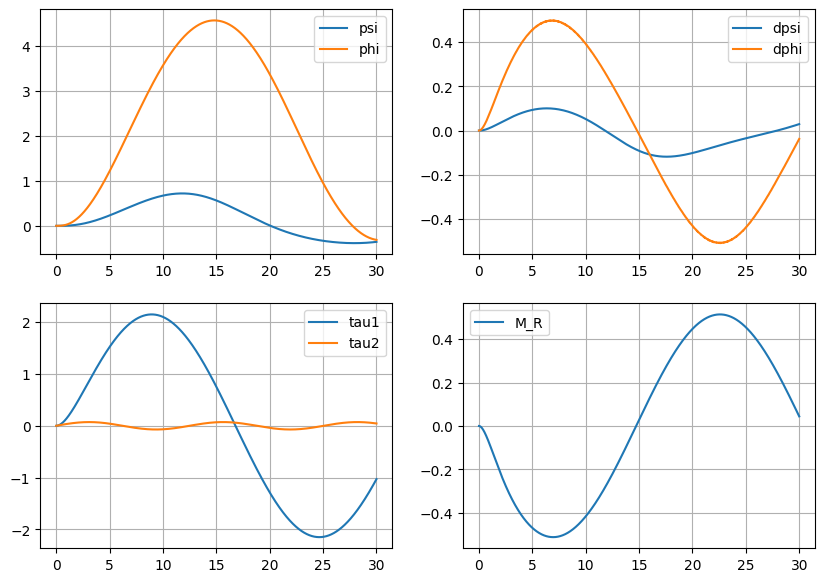

In [340]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10, 7)
ax[0, 0].plot(simulationTime, state[0, :], label='psi')
ax[0, 0].plot(simulationTime, state[2, :], label='phi')
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].plot(simulationTime, state[1, :], label='dpsi')
ax[0, 1].plot(simulationTime, state[3, :], label='dphi')
ax[0, 1].grid()
ax[0, 1].legend()

ax[1, 0].plot(simulationTime, state[4, :], label='tau1')
ax[1, 0].plot(simulationTime, state[5, :], label='tau2')
ax[1, 0].grid()
ax[1, 0].legend()

ax[1, 1].plot(simulationTime, state[6, :], label='M_R')
ax[1, 1].grid()
ax[1, 1].legend()

# 2. Моделирование в пространтсве состояний

In [372]:
A = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [0, -trms_params['B1_psi']/trms_params['I1'], 0, 0, trms_params['b1']/trms_params['I1'], 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, -trms_params['B1_phi']/trms_params['I2'], 0, trms_params['b2']/trms_params['I2'], -1/trms_params['I2']],
    [0, 0, 0, 0, -trms_params['T10']/trms_params['T11'], 0, 0],
    [0, 0, 0, 0, 0, -trms_params['T20']/trms_params['T21'], 0],
    [0, 0, 0, 0, trms_params['kc']*(trms_params['T11']-trms_params['T0']*trms_params['T10'] / (trms_params['Tp']*trms_params['T11'])), 0, -1/trms_params['Tp']]
])

B = np.array([
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [trms_params['k1']/trms_params['T11'], 0],
    [trms_params['k2']/trms_params['T21'], 0],
    [trms_params['kc']*trms_params['T0']*trms_params['k1']/trms_params['Tp'] / trms_params['T11'], 0]
])

C = np.array([
    [1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0]
])
D = np.zeros(shape=(2, 2))
x0 = np.zeros(shape=(7, 1))

def nonlinearity(x):
    x = x.ravel()
    psi, dpsi, phi, dphi, tau1, tau2, M_R = x
    M1 = trms_params['a1'] * tau1**2 + trms_params['b2']*tau2
    f1 = 0
    f2 = (trms_params['a1'] * tau1**2 - trms_params['Mg'] * np.sin(psi) - trms_params['B2_psi'] * np.tanh(dpsi)-\
        trms_params['K_gy']*M1*dphi*np.cos(psi))/trms_params['I1']
    f3 = 0
    f4 = (trms_params['a2'] * tau2**2 - trms_params['B2_phi'] * np.tanh(dphi))/trms_params['I2']
    f5 = 0
    f6 = 0
    f7 = 0
    return np.array([[f1], [f2], [f3], [f4], [f5], [f6], [f7]])

In [373]:
startTime=0
endTime=30
timeSteps=10000
simulationTime=np.linspace(startTime,endTime,timeSteps)

In [374]:
def plant_diff_eq(t, x, trms_params, time_points, u_list):
    u1_list = u_list[0, :]
    u2_list = u_list[1, :]
    u1 = np.interp(t, time_points, u1_list)
    u2 = np.interp(t,time_points, u2_list)    
    if u1 > trms_params['u_upper']: u1 = trms_params['u_upper']
    elif u1 < trms_params['u_lower']: u1 = trms_params['u_lower']
    if u2 > trms_params['u_upper']: u2 = trms_params['u_upper']
    elif u2 < trms_params['u_lower']: u2 = trms_params['u_lower']
    u = np.array([[u1], [u2]])
    
    dxdt = np.matmul(A, x.reshape(-1, 1)) 
    dxdt += np.matmul(B, u)
    nonlin =  nonlinearity(x)
    #nonlinearity =  np.array([[0], [0]])
    dxdt = dxdt + nonlin
    return dxdt.ravel()

In [377]:
u1 = 2*np.sin(0.2 * simulationTime)
u2 = 0.1*np.sin(0.5 * simulationTime+0.5)
u_list = np.c_[u1, u2].T
sol = solve_ivp(plant_diff_eq2, t_span=[0, 30], t_eval=simulationTime, y0=x0.ravel(), method='RK45', args=(trms_params, simulationTime, u_list))
state = sol.y
y_list = np.dot(C ,state)

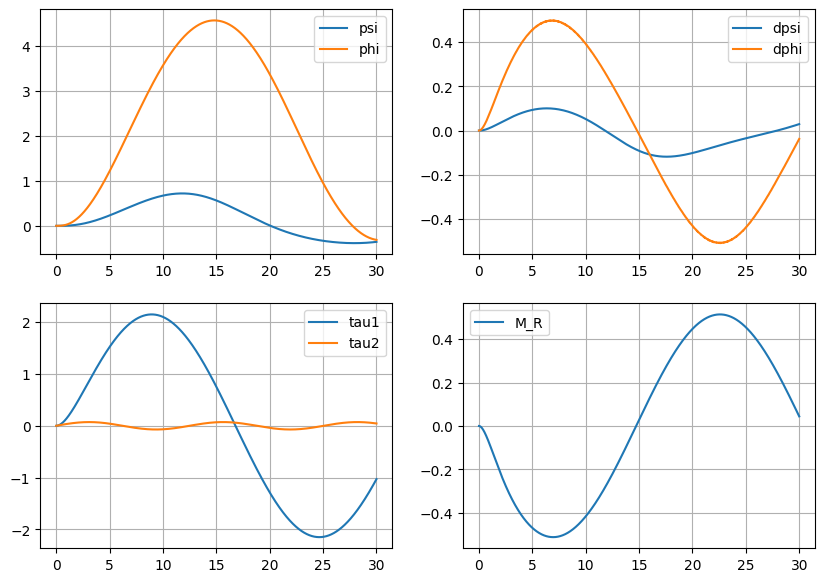

In [378]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10, 7)
ax[0, 0].plot(simulationTime, state[0, :], label='psi')
ax[0, 0].plot(simulationTime, state[2, :], label='phi')
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].plot(simulationTime, state[1, :], label='dpsi')
ax[0, 1].plot(simulationTime, state[3, :], label='dphi')
ax[0, 1].grid()
ax[0, 1].legend()

ax[1, 0].plot(simulationTime, state[4, :], label='tau1')
ax[1, 0].plot(simulationTime, state[5, :], label='tau2')
ax[1, 0].grid()
ax[1, 0].legend()

ax[1, 1].plot(simulationTime, state[6, :], label='M_R')
ax[1, 1].grid()
ax[1, 1].legend()